In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# check the verison
torch.__version__

'2.4.1+cu121'

In [3]:
# check the devicve agnostic mode
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Sat Oct 19 05:26:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# lets create the data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [6]:
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [7]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [8]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [9]:
X_train.shape, X_test.shape

(torch.Size([40, 1]), torch.Size([10, 1]))

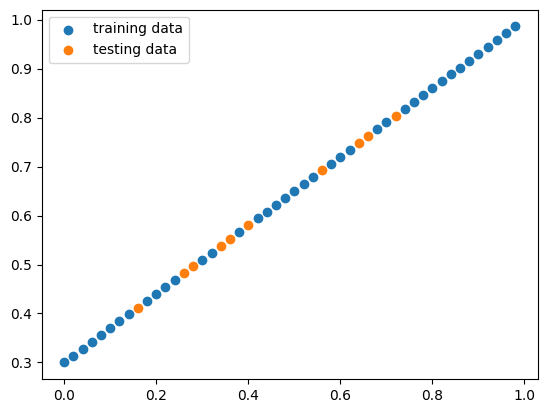

In [10]:
plt.scatter(X_train, y_train, label="training data")
plt.scatter(X_test, y_test, label="testing data")
plt.legend()
plt.show()

In [11]:
# Building a Linear PyTorch model

class LinearModel2(nn.Module):

  def __init__(self):
    super().__init__()

    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self,x):
    return self.linear_layer(x)

torch.manual_seed(3)
model = LinearModel2()
model, model.state_dict()

(LinearModel2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.9915]])),
              ('linear_layer.bias', tensor([-0.7889]))]))

In [12]:
# check the model current device
next(model.parameters()).device

device(type='cpu')

In [13]:
# set the model to use the target device
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Trainig
- loss function
- optimizer
- training loop
- testing loop

In [14]:
# setup loss function
loss_fc = nn.L1Loss()

# setup our optimizer
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.01)

In [15]:
# training loop

torch.manual_seed(42)

epochs = 1000

# put the data on the target device
X_train1 = X_train.to(device)
y_train1 = y_train.to(device)
X_test1 = X_test.to(device)
y_test1 = y_test.to(device)

for epoch in range(epochs):
  model.train()

  # forward pass
  y_pred = model(X_train1)

  # calculate the loss
  loss = loss_fc(y_pred, y_train1)

  # optimizer zero grad
  optimizer.zero_grad()

  # perform backpropagation
  loss.backward()

  # optimizer step
  optimizer.step()

  ## Tesing

  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test1)

    test_loss = loss_fc(test_pred, y_test1)

  # print out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | loss: {loss} | test_loss: {test_loss}")

Epoch: 0 | loss: 1.9396721124649048 | test_loss: 1.8175232410430908
Epoch: 10 | loss: 1.8143714666366577 | test_loss: 1.695492148399353
Epoch: 20 | loss: 1.689070701599121 | test_loss: 1.5734609365463257
Epoch: 30 | loss: 1.5637701749801636 | test_loss: 1.4514297246932983
Epoch: 40 | loss: 1.4384695291519165 | test_loss: 1.329398512840271
Epoch: 50 | loss: 1.3131688833236694 | test_loss: 1.2073673009872437
Epoch: 60 | loss: 1.1878679990768433 | test_loss: 1.0853359699249268
Epoch: 70 | loss: 1.062567114830017 | test_loss: 0.9633046984672546
Epoch: 80 | loss: 0.9372663497924805 | test_loss: 0.841273307800293
Epoch: 90 | loss: 0.8119655847549438 | test_loss: 0.7192421555519104
Epoch: 100 | loss: 0.6866647601127625 | test_loss: 0.597210705280304
Epoch: 110 | loss: 0.5623957514762878 | test_loss: 0.4761793315410614
Epoch: 120 | loss: 0.4640064835548401 | test_loss: 0.37033629417419434
Epoch: 130 | loss: 0.39539599418640137 | test_loss: 0.2840974032878876
Epoch: 140 | loss: 0.34308561682701

In [16]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6988]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2991], device='cuda:0'))])

In [17]:
model.linear_layer.weight, model.linear_layer.bias

(Parameter containing:
 tensor([[0.6988]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2991], device='cuda:0', requires_grad=True))

In [18]:
weight, bias

(0.7, 0.3)

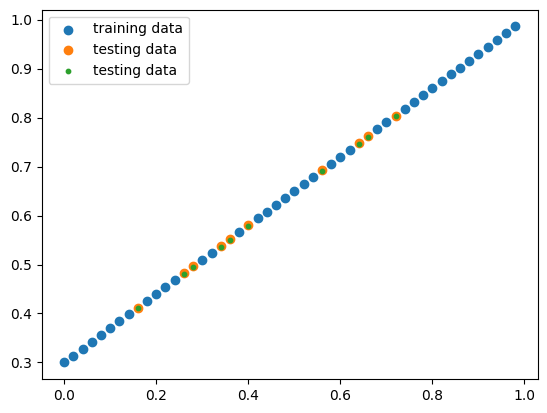

In [19]:
plt.scatter(X_train.cpu(), y_train.cpu(), label="training data")
plt.scatter(X_test.cpu(), y_test.cpu(), label="testing data")

plt.scatter(X_test1.cpu(), test_pred.cpu(), label="testing data", s=10)

plt.legend()
plt.show()